# Introduction to astrostatistics and machine learning with Python

Resources:

Hogg et al. (2010) "Data analysis recipes: Fitting a model to data", http://adsabs.harvard.edu/abs/2010arXiv1008.4686H  
Ivezic et al. (2014) "Statistics, Data Mining, and Machine Learning in Astronomy", http://www.astroml.org/



## Part 1: Fitting a line to data

We are going to start with a simple, straight-forward example often encountered in astronomy: how to fit a line to data. Specifically, we have a set of data $(x, y)$, and we would like to find the best $(m,b)$ such that: 

$$y = mx+b$$

The classical approach to this problem uses a least-squares algorithm, which uses linear algebra. First, we construct our vectors and matrices:

$$
X = \begin{bmatrix}
b \\
m
\end{bmatrix}
$$

$$ Y = \left[ 
             \begin{matrix} 
                y_1 \\
                y_2 \\
                \vdots \\
                y_N
             \end{matrix}
    \right] 
$$

$$ A = 
    \begin{bmatrix} 
        1 & x_1 \\
        1 & x_2 \\
        \vdots & \vdots \\
        1 & x_N
    \end{bmatrix}
$$

$$ C = 
    \begin{bmatrix} 
        \sigma^2_{y_1} & 0 & \dots & 0 \\
        0 & \sigma^2_{y_2} & \dots & 0 \\
        \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & \dots & \sigma^2_{y_N}
    \end{bmatrix}
$$

Using linear algebra we can construct the matrix formula:

$$
Y = A X
$$

Take a second to make sure this makes sense with the definitions of the above vectors and matrices. It should quickly become obvious that there is a problem with the above equation: the problem is over-constrained, and nowhere have we taken into account uncertainties on the measurements. This is where the linear algebra becomes helpful. We can think each row of this matrix equation (data point) as deviating from the linear expectation by some small amount $\epsilon$:

$$
\epsilon = Y - A X
$$

We want to weight each data point by the inverse of its uncertainty then reduce dimensionality into a scalar quantity. We call this quantity $\chi^2$:

$$
\chi^2 \equiv \left[ Y - A X \right]^T C^{-1} \left[ Y - A X \right]
$$

You may have seen $\chi^2$ expressed as the following:

$$
\chi^2 = \sum_{i=1}^N \frac{\left[ y_i - f(x_i) \right]^2}{\sigma^2_{y,i}}
$$

For diagonal covariance matrices, these two formulations are equivalent. The linear algebra version allows for covariances between the data points.

### "...$\chi^2$ is like a metric distance in data space." - Hogg et al. (2010)

Our goal is to minimize $\chi^2$. To get this, we first left multiply both sides of our equation $Y = A X$ by $C^{-1}$ (the inverse of the covariance matrix), which serves to weight each individual data point by its uncertainty. If you think about, this makes sense since smaller uncertainties (smaller values of $\sigma_{y_i}$) should be weighted stronger. Our matrix equation now becomes:

$$
C^{-1} Y = C^{-1} A X
$$

We are almost there. If you look at the dimensionality of the matrices on each side, you'll see that each side is equal to a vector of length $N$. To reduce the dimensionality, we now left-multiply each side by $A^T$. You can convince yourself that this reduces each side to a vector of length 2:

$$
A^T C^{-1} Y = A^T C^{-1} A X
$$

As a last step, we want to solve for $X$, so we left-multiply each side by $\left[ A^T C^{-1} A \right]^{-1}$ obtaining the simple result:

$$ X =
\left[ A^T C^{-1} A \right]^{-1} \left[ A^T C^{-1} Y \right]
$$

It should be clear that, once the matrices $Y$, $A$, and $C$ are defined, this is an extremely easy matrix equation to solve with standard matrix libraries.

Uncertainties are given by:
    

$$
\begin{bmatrix}
\sigma_b^2 & \sigma_{m,b} \\
\sigma_{m,b} & \sigma_m^2
\end{bmatrix} =
\begin{bmatrix}
A^T C^{-1} A
\end{bmatrix}^{-1}
$$

### Let's try this with a simple example

In [1]:
# Load libraries

import numpy as np
from numpy.linalg import inv
from astropy.table import Table
import matplotlib.pyplot as plt

%matplotlib inline

### Let's take some data from the literature for RR Lyrae stars in M4

RR Lyrae stars are variable pulsators that obey a precise period-luminosity relation. As such they are used as a distance indicator. Here we will attempt to determine the distance to the globular cluster M4 using a sample of 37 RR Lyrae stars observed with Spitzer by Neeley et al. (2015): http://cdsads.u-strasbg.fr/abs/2015ApJ...808...11N

The FU class of RR Lyrae follow the relation:

$$
m = m\ ({\rm log}\ P + 0.26) + b
$$

In [2]:
# First we use astropy tables to load the data, which we obtained directly from CDS

readme = './ReadMe'
RR_lyrae_table2 = Table.read('./table2.dat', readme=readme, format='cds')

# We will select just the 'FU' type RR Lyraes
RR_lyrae = RR_lyrae_table2[np.where(RR_lyrae_table2['Mode'] == 'RRab')]

# Now remove sources V20 and V21 due to blending
RR_lyrae = RR_lyrae[np.where(RR_lyrae['ID'] != 'V20')[0]]
RR_lyrae = RR_lyrae[np.where(RR_lyrae['ID'] != 'V21')[0]]
print(RR_lyrae.colnames)

['ID', 'RAh', 'RAm', 'RAs', 'DE-', 'DEd', 'DEm', 'DEs', 'Per', 'logP', '[3.6]', 'e_[3.6]', 'f_[3.6]', '[4.5]', 'e_[4.5]', 'f_[4.5]', '3.6amp', 'e_3.6amp', '4.5amp', 'e_4.5amp', 'Mode', 'f_Mode']


/usr/local/lib/python3.7/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


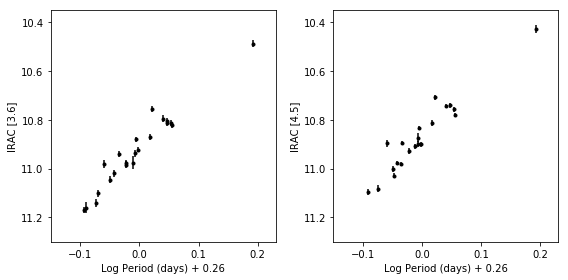

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

# Axis limits
for i in np.arange(2):
    ax[i].set_ylim(11.3, 10.35)
    ax[i].set_xlim(-0.15, 0.23)
    ax[i].set_xticks([-0.1, 0.0, 0.1, 0.2])

# Plot 3.6 micron data
ax[0].errorbar(RR_lyrae['logP']+0.26, RR_lyrae['[3.6]'], yerr=RR_lyrae['e_[3.6]'], fmt='o', marker='.', color='k')
# Plot 4.5 micron data
ax[1].errorbar(RR_lyrae['logP']+0.26, RR_lyrae['[4.5]'], yerr=RR_lyrae['e_[4.5]'], fmt='o', marker='.', color='k')


# Plot labels
ax[0].set_xlabel('Log Period (days) + 0.26')
ax[1].set_xlabel('Log Period (days) + 0.26')
ax[0].set_ylabel('IRAC [3.6]')
ax[1].set_ylabel('IRAC [4.5]')


plt.tight_layout()
plt.show()

### Now, let's define our matrices as we did above to calculate the best fit line

In [4]:
def calc_best_fit(data_x, data_y, data_y_err):
    """ Calculate the best fit line values """
    
    Y = np.matrix(data_y).T                         # The y-values
    N = Y.size                                      # The number of observations

    A = np.ones((N, 2))                             # Create a 2xN matrix of 1's
    A[:,1] = data_x + 0.26                          # Set the second row to the x-values
    A = np.matrix(A)                                # Convert numpy array to a numpy matrix

    C = np.identity(N) * data_y_err                 # Create the covariance matrix
    C = np.matrix(C)                                # Convert numpy array to a numpy matrix

    X = inv(A.T * inv(C) * A) * (A.T * inv(C) * Y)  # Our solution vector
    
    return np.array(X)                              # Convert back from numpy matrix to numpy array


def calc_uncertainties(data_x, data_y_err):
    """ Calculate uncertainties on these values """
    
    N = len(data_x)                                 # The number of observations
    
    A = np.ones((N, 2))                             # Create a 2xN matrix of 1's
    A[:,1] = data_x + 0.26                          # Set the second row to the x-values
    A = np.matrix(A)
    
    C = np.identity(N) * data_y_err                 # Create the covariance matrix
    C = np.matrix(C)                                # Convert numpy array to a numpy matrix

    cov = inv(A.T * inv(C) * A)                     # Calculate the uncertainties

    return np.array(cov)

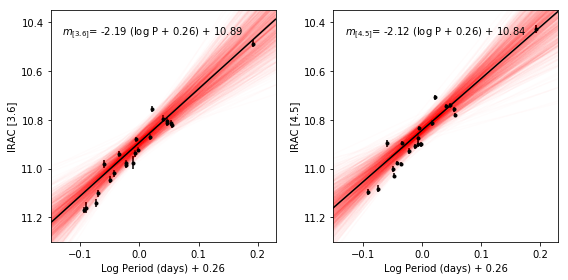

In [5]:
def plot_line(ax, b, m, mag):
    """ To plot the best fit line """
    
    x = ax.get_xlim()
    y = m*x + b
    
    ax.plot(x, y, color='k')
    
    # Display the best fit values
    ax.text(-0.13, 10.45, mag + '= ' + str(np.around(m[0], decimals=2)) + ' (log P + 0.26) + ' + str(np.around(b[0], decimals=2)))

    
def plot_lines(ax, b, m, cov, mag):
    """ To plot 50 lines, randomly chosen from the best fit values and their covariances """
    
    # Calculate outputs
    mean = np.array([b[0], m[0]])
    x_out = np.random.multivariate_normal(mean, cov, size=1000)
    
    x = ax.get_xlim()

    # Plot lines
    for i in np.arange(1000):
        
        b_tmp, m_tmp = x_out[i]
        
        y = np.array([m_tmp])*x + np.array([b_tmp])
        ax.plot(x, y, color='r', alpha=0.01)



    

fig, ax = plt.subplots(1, 2, figsize=(8,4))

# Axis limits
for i in np.arange(2):
    ax[i].set_ylim(11.3, 10.35)
    ax[i].set_xlim(-0.15, 0.23)
    ax[i].set_xticks([-0.1, 0.0, 0.1, 0.2])

# Plot 3.6 micron data
b, m = calc_best_fit(RR_lyrae['logP'], RR_lyrae['[3.6]'], RR_lyrae['e_[3.6]'])
cov = calc_uncertainties(RR_lyrae['logP'], RR_lyrae['e_[3.6]'])
plot_lines(ax[0], b, m, cov, r'$m_{[3.6]}$')
plot_line(ax[0], b, m, r'$m_{[3.6]}$')

# Plot 4.5 micron data
b, m = calc_best_fit(RR_lyrae['logP'], RR_lyrae['[4.5]'], RR_lyrae['e_[4.5]'])
cov = calc_uncertainties(RR_lyrae['logP'], RR_lyrae['e_[4.5]'])
plot_lines(ax[1], b, m, cov, r'$m_{[4.5]}$')
plot_line(ax[1], b, m, r'$m_{[4.5]}$')

# Plot points and their uncertainties
ax[0].errorbar(RR_lyrae['logP']+0.26, RR_lyrae['[3.6]'], yerr=RR_lyrae['e_[3.6]'], fmt='o', marker='.', color='k')
ax[1].errorbar(RR_lyrae['logP']+0.26, RR_lyrae['[4.5]'], yerr=RR_lyrae['e_[4.5]'], fmt='o', marker='.', color='k')


# Plot labels
ax[0].set_xlabel('Log Period (days) + 0.26')
ax[1].set_xlabel('Log Period (days) + 0.26')
ax[0].set_ylabel('IRAC [3.6]')
ax[1].set_ylabel('IRAC [4.5]')




plt.tight_layout()
plt.show()

### Deriving the distance from our results

Now, we will keep the slope we have just derived, but use five Galactic RR Lyrae to calibrate the zero point of the period-luminosity relation. From these, we get the following relations:

$$
M_{[3.6]} = -2.19\ {\rm log}\ P - 1.176
$$

$$
M_{[4.5]} = -2.12\ {\rm log}\ P - 1.199
$$

Comparing these relations to our observed relations, we get:

$$
m_{[3.6]} = -2.19\ ({\rm log}\ P + 0.26) + 10.89
$$

$$
m_{[4.5]} = -2.12\ ({\rm log}\ P + 0.26) + 10.84
$$

Subtracting the two, we get two measurements for a distance modulus:

$$
\mu_{[3.6]} = \left( m_{[3.6]} - M_{[3.6]} \right) = 11.497
$$

$$
\mu_{[4.5]} = \left( m_{[4.5]} - M_{[4.5]} \right) = 11.488
$$

This modulus implies a distance:

$$
D = 1993\ {\rm pc}: \lambda\ =\ 3.6\ \mu {\rm m}
$$

$$
D = 1984\ {\rm pc}: \lambda\ =\ 4.5\ \mu {\rm m}
$$

### Summary:

### This method has several benefits:

1. Non-parametric

2. Uses standard linear algebra techniques

3. Can be abstracted to higher order polynomials

### But, this is a somewhat specialized situation. The above equation for $X^2$ has three assumptions built-in:

1. Outliers were pruned by hand

2. Uncertainties are Gaussian

3. Uncertainties only on the y-axis

4. Can't add lower or upper limits


### When any of these four assumptions are broken, more complicated models are required 

## Part 2: Motivation for Machine Learning Techniques

Let's say you need to obtain a large sample of white dwarfs (WDs). You might decide that SDSS, with its $ugriz$ photometry is a good option to search from. But how do we separate WDs from other stars using this photometric data? Let's take an example from my work (Andrews et al. 2012) where I had to do exactly this. Below is a plot that demonstrates the progression of techniques.

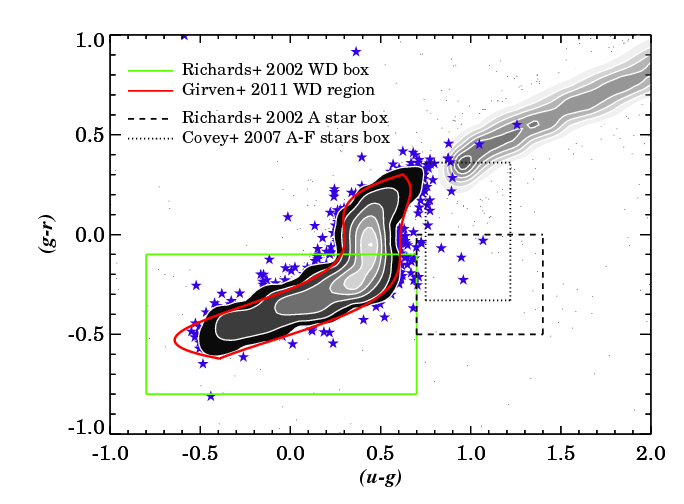

In [6]:
# Use wand to open pdf images
from wand.image import Image

# Figure 3 from Andrews et al. (2012)
img = Image(filename='./catalog_colors_7.pdf')
img.rotate(-90)
img

As they are hot objects, WD are best identified by their colors in the bluest SDSS bands, $u-g$ and $g-r$. Older criteria for identifying WDs (Richards et al. (2002) in the figure) relied on simple "boxy" color-color ranges. The blue stars (and black/gray contours) designate spectroscopically confirmed WDs. The white/gray contours designate contaminating, early-type main sequence stars.

Clearly, the Richards et al. (2002) criteria (and any "box" region, really) are going to both a) miss *lots* of WDs, and b) potentially add non-WDs to our sample.

It should be obvious that the Girven et al. (2011) criteria is a substantial improvement. This is a 5th order polynomial fit to the distribution.

### Have we solved the problem?

Looking at the figure above, we may be tempted to think we have solved the problem - the WD locus is clearly well defined, and there is no (minimal) overlap with the early-type stellar locus. Unfortunately, the limits placed by Girven et al. (2011) are defined for WDs with $g<19$, but SDSS goes more than a magnitude fainter.

"But wait!" you say, "the colors of WDs should not depend on distance." True! But at magnitudes fainter than $g\sim 18$, quasars become a significant source of contamination. See a figure below from a more recent paper.

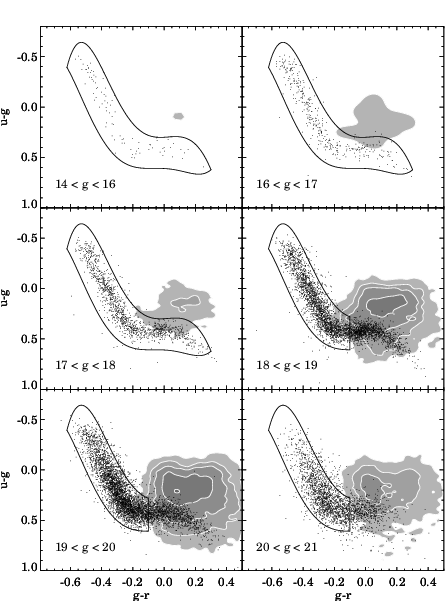

In [7]:
# Figure 5 from Andrews et al. (2015)
img = Image(filename='./WD_colors_mag.pdf')
img.rotate(-90)
img

Photometrically identified WDs (from a subset that has IR photometry) are shown by the dots, while the contours show quasars. At magnitudes fainter than $g\sim 18$, contamination from quasars is clearly substantial. Blindly using the Girven et al. (2011) criteria will lead to lots of contamination. My solution was to cut off the end of the distribution for fainter magnitudes.

### Can we do better? Of course!

Note: You can almost *always* do better, but at some point improvements are not worth the time required to implement. As a rule, the approach (and work required to implement) should be justified by the science goal. 

In data science, this is an example of a genre of problems called classification or supervised learning: We would like to "classify" a set of data points of unknown type using a training data set of known type. In this case, we will use catalogs of spectroscopically confirmed WDs (Kleinman et al. 2013) and quasars (Schneider et al. 2010) as our training data sets.

Let's plot the WDs, quasars, and a sample of ~1.6 million objects in SDSS with $u-g<0.8$ and $g-r<0.5$

In [15]:
# Load the data
data_dir = './'

SDSS_blue = np.genfromtxt(open(data_dir + 'SDSS_blue_objs.dat', 'rb'), names=True)
quasars = np.genfromtxt(open(data_dir + 'schneider_quasars.dat', 'rb'), names=True)
DA_WDs = np.genfromtxt(open(data_dir + 'DA_kleinman.dat', 'rb'), names=True)
DB_WDs = np.genfromtxt(open(data_dir + 'DB_kleinman.dat', 'rb'), names=True)

print("We have samples of spectroscopically confirmed objects:")
print(len(DA_WDs), "DA white dwarfs")
print(len(DB_WDs), "DB white dwarfs")
print(len(quasars), "quasars")
print("")
print("We have", len(SDSS_blue), "blue stars in SDSS we would like to classify.")

We have samples of spectroscopically confirmed objects:
12334 DA white dwarfs
886 DB white dwarfs
105759 quasars

We have 1663384 blue stars in SDSS we would like to classify.


### Let's plot a color-color diagram and a color-magnitude diagram

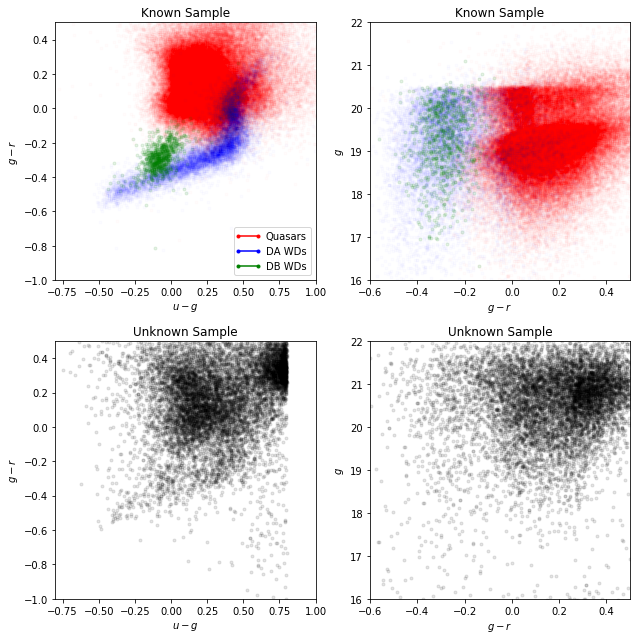

In [16]:
def plot_data(ax, SDSS_samp, colors):

    # Plot the color-color data
    ax[0,0].set_title('Known Sample')
    ax[0,0].scatter(quasars['u']-quasars['g'], quasars['g']-quasars['r'], marker='.', alpha=0.01, color='r')
    ax[0,0].scatter(DA_WDs['u']-DA_WDs['g'], DA_WDs['g']-DA_WDs['r'], marker='.', alpha=0.01, color='b')
    ax[0,0].scatter(DB_WDs['u']-DB_WDs['g'], DB_WDs['g']-DB_WDs['r'], marker='.', alpha=0.1, color='g')
    ax[1,0].set_title('Unknown Sample')
    ax[1,0].scatter(SDSS_samp['u']-SDSS_samp['g'], SDSS_samp['g']-SDSS_samp['r'], marker='.', alpha=0.1, color=colors)



    # Plot the color-magnitude
    ax[0,1].set_title('Known Sample')
    ax[0,1].scatter(quasars['g']-quasars['r'], quasars['g'], marker='.', alpha=0.01, color='r')
    ax[0,1].scatter(DA_WDs['g']-DA_WDs['r'], DA_WDs['g'], marker='.', alpha=0.01, color='b')
    ax[0,1].scatter(DB_WDs['g']-DB_WDs['r'], DB_WDs['g'], marker='.', alpha=0.1, color='g')
    ax[1,1].set_title('Unknown Sample')
    ax[1,1].scatter(SDSS_samp['g']-SDSS_samp['r'], SDSS_samp['g'], marker='.', alpha=0.1, color=colors)


    # Add the legend
    ax[0,0].plot(np.NaN, np.NaN, color='r', label='Quasars')
    ax[0,0].plot(np.NaN, np.NaN, color='b', label='DA WDs')
    ax[0,0].plot(np.NaN, np.NaN, color='g', label='DB WDs')
    leg = ax[0,0].legend(loc=4)
    for l in leg.get_lines():
        l.set_alpha(1.0)
        l.set_marker('.')




    for i in np.arange(2):
        # Set the plot limits
        ax[i,0].set_xlim(-0.8, 1.0)
        ax[i,0].set_ylim(-1.0, 0.5)
        ax[i,1].set_xlim(-0.6, 0.5)
        ax[i,1].set_ylim(16.0, 22.0)

        # Add the plot labels
        ax[i,0].set_xlabel(r'$u-g$')
        ax[i,0].set_ylabel(r'$g-r$')
        ax[i,1].set_xlabel(r'$g-r$')
        ax[i,1].set_ylabel(r'$g$')

        
        
fig, ax = plt.subplots(2, 2, figsize=(9, 9))


# We'll select 10000 random samples of the ~4 million SDSS stars
n_samp = 10000
idx = np.random.randint(len(SDSS_blue), size=n_samp)
SDSS_samp = SDSS_blue[idx]
colors = np.ones(n_samp, dtype='S11')
colors = 'k'

plot_data(ax, SDSS_samp, colors)
        
plt.tight_layout()
plt.show()

### We'll use an algorithm called a support vector machine

In [33]:
# Select a subset of the quasar data
n_samp = 15000
idx = np.random.randint(len(quasars), size=n_samp)

# First, we construct our training sets
quasar_mags = quasars[['u','g','r','i','z']].view(np.float64).reshape(quasars[['u','g','r','i','z']].shape + (-1,))
DA_WD_mags = DA_WDs[['u','g','r','i','z']].view(np.float64).reshape(DA_WDs[['u','g','r','i','z']].shape + (-1,))
DB_WD_mags = DB_WDs[['u','g','r','i','z']].view(np.float64).reshape(DB_WDs[['u','g','r','i','z']].shape + (-1,))

data = np.copy(quasar_mags[idx])
data = np.vstack((data, DA_WD_mags))
data = np.vstack((data, DB_WD_mags))


# Generate an array of the class labels
classes = 1 * np.ones(n_samp)
classes = np.append(classes, 2 * np.ones(len(DA_WD_mags)))
classes = np.append(classes, 3 * np.ones(len(DB_WD_mags)))

In [34]:
from sklearn.svm import SVC, LinearSVC

clf = SVC(kernel='rbf', gamma=10.0, class_weight=None)
#clf = LinearSVC(loss='l2')
clf.fit(data, classes)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### We'll perform a simple (incorrect) test by trying to guess the classes of known objects

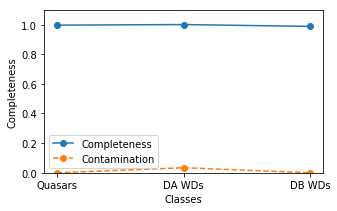

In [35]:
classes_out_quasars = clf.predict(quasar_mags)
classes_out_DA_WDs = clf.predict(DA_WD_mags)
classes_out_DB_WDs = clf.predict(DB_WD_mags)


completeness_quasars = float(len(np.where(classes_out_quasars == 1)[0])) / float(len(quasar_mags))
n_tot_quasars = len(np.where(classes_out_quasars == 1)[0]) + len(np.where(classes_out_DA_WDs == 1)[0]) + len(np.where(classes_out_DB_WDs == 1)[0])
contamination_quasars = float(len(np.where(classes_out_DA_WDs == 1)[0]) + len(np.where(classes_out_DB_WDs == 1)[0])) / n_tot_quasars

completeness_DA_WDs = float(len(np.where(classes_out_DA_WDs == 2)[0])) / float(len(DA_WD_mags))
n_tot_DA_WDs = len(np.where(classes_out_quasars == 2)[0]) + len(np.where(classes_out_DA_WDs == 2)[0]) + len(np.where(classes_out_DB_WDs == 2)[0])
contamination_DA_WDs = float(len(np.where(classes_out_quasars == 2)[0]) + len(np.where(classes_out_DB_WDs == 2)[0])) / n_tot_DA_WDs

completeness_DB_WDs = float(len(np.where(classes_out_DB_WDs == 3)[0])) / float(len(DB_WD_mags))
n_tot_DB_WDs = len(np.where(classes_out_quasars == 3)[0]) + len(np.where(classes_out_DA_WDs == 3)[0]) + len(np.where(classes_out_DB_WDs == 3)[0])
contamination_DB_WDs = float(len(np.where(classes_out_quasars == 3)[0]) + len(np.where(classes_out_DA_WDs == 3)[0])) / n_tot_DB_WDs



fig, ax = plt.subplots(1, 1, figsize=(5,3))

ax.plot([1, 2, 3], [completeness_quasars, completeness_DA_WDs, completeness_DB_WDs], 
        marker='o', label='Completeness')
ax.plot([1, 2, 3], [contamination_quasars, contamination_DA_WDs, contamination_DB_WDs], 
        marker='o', linestyle='--', label='Contamination')
ax.set_ylim(0, 1.1)
ax.set_xlim(0.9, 3.1)

ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["Quasars", "DA WDs", "DB WDs"])

ax.set_yticks(np.linspace(0,1,6))

ax.set_xlabel('Classes')
ax.set_ylabel('Completeness')

ax.legend()

plt.show()

When running our samples back through the SVM, we find completenesses of >90%. This is not surprising, since we are checking with the same data we trained on. Ideally, we would have kept a small subset of the training data out of the analysis, and run that data through the SVM to validate its effectiveness.

### Now, we run the entire 1.6 million SDSS objects through the SVM

In [40]:
# Select a subset of the quasar data
n_samp = 100000

# Allocate array to zeros
classes_SDSS = np.zeros(len(SDSS_blue), dtype='int64')

# Calculate SVM class in batches of 10^5
for i in np.arange(np.ceil(float(len(SDSS_blue))/float(n_samp))):
        
    idx = np.arange(np.min([n_samp, np.abs(int(i+1)*n_samp - len(SDSS_blue))])) + int(i)*n_samp
    print(np.min(idx))
    
    SDSS_samp = SDSS_blue[idx]
    SDSS_samp_mags = SDSS_samp[['u','g','r','i','z']].view(np.float64).reshape(SDSS_samp[['u','g','r','i','z']].shape + (-1,))
    
    classes_SDSS[idx] = clf.predict(SDSS_samp_mags)
    

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000


### Now, let's compare the training set with the results of our classification algorithm

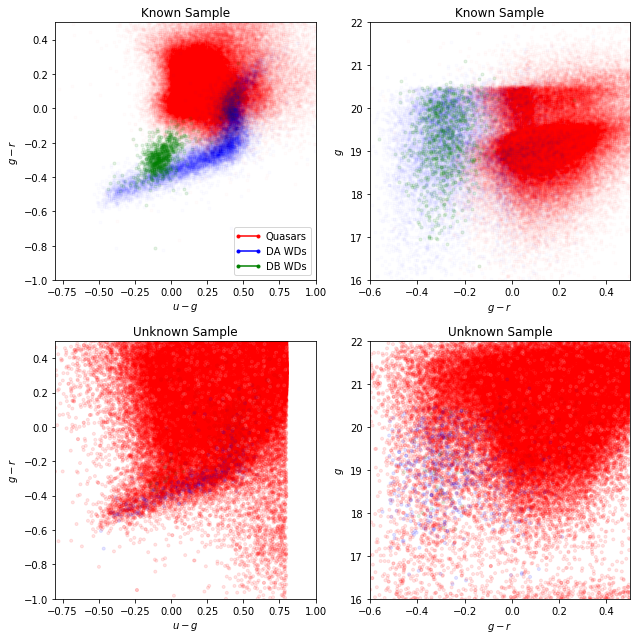

In [41]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))


# We'll select 10000 random samples of the ~4 million SDSS stars
n_samp = 100000
idx = np.random.randint(len(SDSS_blue), size=n_samp)
SDSS_samp = SDSS_blue[idx]


colors = np.ones(n_samp, dtype='U11')
colors[classes_SDSS[idx] == 1] = 'r'  # Quasars
colors[classes_SDSS[idx] == 2] = 'b'  # DA WDs
colors[classes_SDSS[idx] == 3] = 'g'  # DB WDs


plot_data(ax, SDSS_samp, colors)
        
plt.tight_layout()
plt.show()

In [42]:
print("We have found", len(np.where(classes_SDSS == 2)[0]), 'DA WDs')
print("We have found", len(np.where(classes_SDSS == 3)[0]), 'DB WDs')

We have found 13222 DA WDs
We have found 534 DB WDs


The latest survey to identify WDs photometrically (Fusillo et al. 2015, http://adsabs.harvard.edu/abs/2015ASPC..493..437G) presents a catalog that "contains over 20,000 high-confidence WDs and WD candidates 11,500 of which have not yet been followed up with Sloan spectroscopy". With a few dozen lines of code, we've found >13,000 candidates.

While a *lot* more work would have to go into making this data set publishable, it should be clear that machine learning methods hold great potential for modern astrophysical problems.